In [43]:
from datetime import datetime

def parse_timestamp(timestamp1, timestamp2):
    fmt = '%Y-%m-%d %H:%M:%S.%f'
    tstamp1 = datetime.strptime(timestamp1, fmt)
    tstamp2 = datetime.strptime(timestamp2, fmt)

    if tstamp1 > tstamp2:
        td = tstamp1 - tstamp2
    else:
        td = tstamp2 - tstamp1
    
    return td.total_seconds()

timestamp1 = "2024-12-05 23:59:59.999"
timestamp2 = "2024-12-06 00:00:00.017"
print(f'The difference is approx. {parse_timestamp(timestamp1, timestamp2)} seconds')

The difference is approx. 0.018 seconds


In [44]:
def create_network_data_1(file_name):
    results_file = open(file_name)
    results_dict = {
        "timestamps": [],
        "cwnd": [],
        "ssthresh": [],
        "throughput": [],
        "mean_rtt": [],
        "rtt_var": [],
    }

    # Initialize variables
    prev_timestamp = results_file.readline()[1:-2]
    results_dict["timestamps"].append(0)
    mss = -1 # Initializing MSS
    conversion_factors_bitrate = {"Gbps": pow(10,3), "Mbps": 1, "kbps": pow(10,-3)}

    # Parse log file
    for line in results_file:
        line = line.strip()
        if "[" in line:
            # Fill missing throughput (delivery_rate) and ssthresh with 0
            if len(results_dict["throughput"]) < len(results_dict["timestamps"]):
                results_dict["throughput"].append(0)
            if len(results_dict["ssthresh"]) < len(results_dict["timestamps"]):
                results_dict["ssthresh"].append(0)

            curr_timestamp = line[1:-1]
            elapsed_time = parse_timestamp(prev_timestamp, curr_timestamp)
            results_dict["timestamps"].append(results_dict["timestamps"][-1] + elapsed_time)
            prev_timestamp = curr_timestamp
        elif "mss" in line:
            mss = int(line[4:])

        elif "cwnd" in line:
            cwnd_bits = int(line[5:]) * mss * 8
            results_dict["cwnd"].append(cwnd_bits)

        elif "ssthresh" in line:
            ssthresh_bits = int(line[9:]) * mss * 8
            results_dict["ssthresh"].append(ssthresh_bits)

        elif "delivery_rate" in line:
            throughput_value = float(line[14:-4])
            unit = line[-4:]
            converted_throughput = conversion_factors_bitrate[unit] * throughput_value
            results_dict["throughput"].append(converted_throughput)

        elif "rtt" in line:
            rtt_val = line[4:].split('/')
            results_dict["mean_rtt"].append(float(rtt_val[0]))
            results_dict["rtt_var"].append(float(rtt_val[1]))

    # Handle remaining missing throughput and ssthresh entries
    while len(results_dict["throughput"]) < len(results_dict["timestamps"]):
        results_dict["throughput"].append(0)
    while len(results_dict["ssthresh"]) < len(results_dict["timestamps"]):
        results_dict["ssthresh"].append(0)

    return results_dict

In [45]:
def create_network_data_2(file_name, start_timestamp):
    results_file = open(file_name)
    results_dict = {
        "timestamps": [],
        "cwnd": [],
        "ssthresh": [],
        "throughput": [],
        "mean_rtt": [],
        "rtt_var": [],
    }

    # Initialize variables
    prev_timestamp = results_file.readline()[1:-2]
    start_time = parse_timestamp(start_timestamp, prev_timestamp)    
    results_dict["timestamps"].append(start_time)
    mss = -1 # Initializing MSS
    conversion_factors_bitrate = {"Gbps": pow(10,3), "Mbps": 1, "kbps": pow(10,-3)}

    # Parse log file
    for line in results_file:
        line = line.strip()
        if "[" in line:
            # Fill missing throughput (delivery_rate) and ssthresh with 0
            if len(results_dict["throughput"]) < len(results_dict["timestamps"]):
                results_dict["throughput"].append(0)
            if len(results_dict["ssthresh"]) < len(results_dict["timestamps"]):
                results_dict["ssthresh"].append(0)

            curr_timestamp = line[1:-1]
            elapsed_time = parse_timestamp(prev_timestamp, curr_timestamp)
            results_dict["timestamps"].append(results_dict["timestamps"][-1] + elapsed_time)
            prev_timestamp = curr_timestamp
        elif "mss" in line:
            mss = int(line[4:])

        elif "cwnd" in line:
            cwnd_bits = int(line[5:]) * mss * 8
            results_dict["cwnd"].append(cwnd_bits)

        elif "ssthresh" in line:
            ssthresh_bits = int(line[9:]) * mss * 8
            results_dict["ssthresh"].append(ssthresh_bits)

        elif "delivery_rate" in line:
            throughput_value = float(line[14:-4])
            unit = line[-4:]
            converted_throughput = conversion_factors_bitrate[unit] * throughput_value
            results_dict["throughput"].append(converted_throughput)

        elif "rtt" in line:
            rtt_val = line[4:].split('/')
            results_dict["mean_rtt"].append(float(rtt_val[0]))
            results_dict["rtt_var"].append(float(rtt_val[1]))

    # Handle remaining missing throughput and ssthresh entries
    while len(results_dict["throughput"]) < len(results_dict["timestamps"]):
        results_dict["throughput"].append(0)
    while len(results_dict["ssthresh"]) < len(results_dict["timestamps"]):
        results_dict["ssthresh"].append(0)

    return results_dict

In [46]:
file_name1 = "cubic-20ms-delay-f"
results_1 = open(f"./results/{file_name1}.txt")
results_dict1 = create_network_data_1(f"./results/{file_name1}.txt")

start_timestamp1 = results_1.readline()[1:-2]
file_name2 = "cubic-20ms-delay-f2"
results_dict2 = create_network_data_2(f"./results/{file_name2}.txt", start_timestamp1)

In [47]:
file_name3 = "bbr-20ms-delay-f"
results_2 = open(f"./results/{file_name3}.txt")
results_dict3 = create_network_data_1(f"./results/{file_name3}.txt")

start_timestamp2 = results_2.readline()[1:-2]
file_name4 = "bbr-20ms-delay-f2"
results_dict4 = create_network_data_2(f"./results/{file_name4}.txt", start_timestamp2)

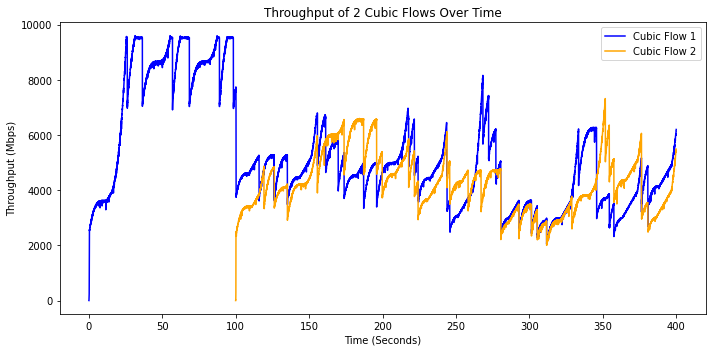

In [ ]:
# Throughput of 2 Cubic Flows under 20ms delay
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

# Throughput
axs.plot(results_dict1["timestamps"], results_dict1["throughput"], label="Cubic Flow 1", color='blue')
axs.plot(results_dict2["timestamps"], results_dict2["throughput"], label="Cubic Flow 2", color='orange')
axs.set_xlabel('Time (Seconds)', fontsize=16)
axs.set_ylabel('Throughput (Mbps)', fontsize=16)
axs.set_title('Throughput of 2 Cubic Flows Over Time', fontsize=16)

# ssthresh
plt.legend()
plt.tight_layout()
plt.savefig(f"./results/{file_name1}.png")
plt.show()


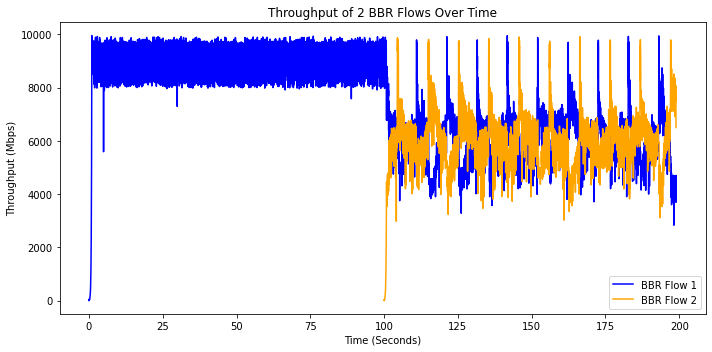

In [ ]:
# Throughput of 2 BBR Flows under 20ms delay
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

# Throughput
# I ran out of network credits after a point hence had to crop the latter part of the graph
axs.plot(results_dict3["timestamps"][:-6269], results_dict3["throughput"][:-6269], label="BBR Flow 1", color='blue')
axs.plot(results_dict4["timestamps"][:-6269], results_dict4["throughput"][:-6269], label="BBR Flow 2", color='orange')
axs.set_xlabel('Time (Seconds)', fontsize=16)
axs.set_ylabel('Throughput (Mbps)', fontsize=16)
axs.set_title('Throughput of 2 BBR Flows Over Time', fontsize=16)

plt.legend()
plt.tight_layout()
plt.savefig(f"./results/{file_name3}.png")
plt.show()
